In [1]:
import pandas as pd
import numpy as np

# experiment list
norms_list = ['normal','MinMax', 'BN', 'LN', 'IN', 'RevIN']
dataset_list = ['etth1', 'etth2', 'ettm1', 'ettm2']
model_list = ['lstm', 'SCINet', 'Informer', 'Transformer']

# default setup
seq_len = 24 * 4 * 4
pred_len = 24 * 4
stride = 4
dist = 0

# dataset
from src.config import Config
from src.dataset import CustomDataset
from src.utils import split_data
from src.feature_extraction import time_features

config = Config()

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv(config.DATA_PATH["etth1"])
print("etth1 : {} rows, {} features".format(len(data), len(data.columns)))
data = pd.read_csv(config.DATA_PATH["etth2"])
print("etth2 : {} rows, {} features".format(len(data), len(data.columns)))
data = pd.read_csv(config.DATA_PATH["ettm1"])
print("ettm1 : {} rows, {} features".format(len(data), len(data.columns)))
data = pd.read_csv(config.DATA_PATH["ettm2"])
print("ettm2 : {} rows, {} features".format(len(data), len(data.columns)))

etth1 : 17420 rows, 8 features
etth2 : 17420 rows, 8 features
ettm1 : 69680 rows, 8 features
ettm2 : 69680 rows, 8 features


In [3]:
data = pd.read_csv(config.DATA_PATH["etth1"])
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


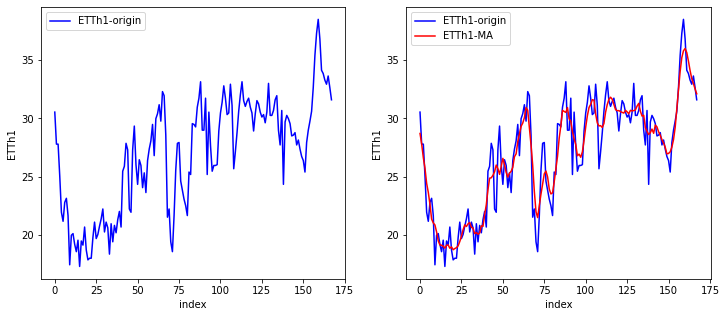

In [4]:
import matplotlib.pyplot as plt
idx_srt = 0
idx_end = 24 * 7
data = pd.read_csv(config.DATA_PATH["etth1"])
fig, axes = plt.subplots(1,2, figsize = (12,5))

axes[0].plot(data['date'].iloc[idx_srt:idx_end].index, data['OT'].iloc[idx_srt:idx_end], 'b', label = 'ETTh1-origin')
axes[1].plot(data['date'].iloc[idx_srt:idx_end].index, data['OT'].iloc[idx_srt:idx_end], 'b', label = 'ETTh1-origin')
axes[0].set_xlabel('index')
axes[0].set_ylabel('ETTh1')
axes[0].legend()

# Moving Average
data[config.src_cols] = data[config.src_cols].rolling(window = 6, min_periods=1, center=True, win_type=None, on=None, axis=0).mean().values

axes[1].plot(data['date'].iloc[idx_srt:idx_end].index, data['OT'].iloc[idx_srt:idx_end], 'r', label = 'ETTh1-MA')
axes[1].set_xlabel('index')
axes[1].set_ylabel('ETTh1')
axes[1].legend()

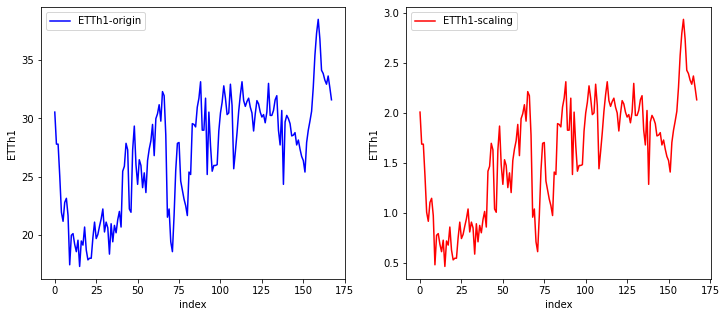

In [5]:
# scaling
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()

idx_srt = 0
idx_end = 24 * 7
data = pd.read_csv(config.DATA_PATH["etth1"])
fig, axes = plt.subplots(1,2, figsize = (12,5))

axes[0].plot(data['date'].iloc[idx_srt:idx_end].index, data['OT'].iloc[idx_srt:idx_end], 'b', label = 'ETTh1-origin')
axes[0].set_xlabel('index')
axes[0].set_ylabel('ETTh1')
axes[0].legend()

# standard scaling
data[config.src_cols] = scaler.fit_transform(data[config.src_cols])
axes[1].plot(data['date'].iloc[idx_srt:idx_end].index, data['OT'].iloc[idx_srt:idx_end], 'r', label = 'ETTh1-scaling')
axes[1].set_xlabel('index')
axes[1].set_ylabel('ETTh1')
axes[1].legend()

In [6]:
data = pd.read_csv(config.DATA_PATH["ettm1"])
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


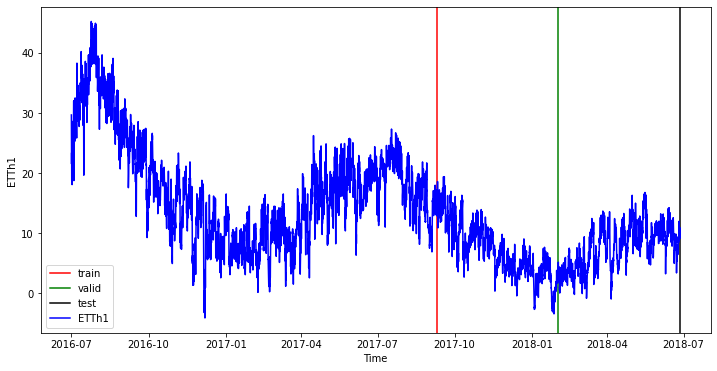

In [7]:

data = pd.read_csv(config.DATA_PATH["ettm1"])
data.date = pd.to_datetime(data.date)

data[config.src_cols] = data[config.src_cols].rolling(window = 6, min_periods=1, center=True, win_type=None, on=None, axis=0).mean().values

ts_train, ts_valid, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

plt.figure(figsize = (12,6))
plt.axvline(x = ts_train['date'].iloc[-1], ymin = 0, ymax = 1, c = 'r', label = 'train')
plt.axvline(x = ts_valid['date'].iloc[-1], ymin = 0, ymax = 1, c = 'g', label = 'valid')
plt.axvline(x = ts_test['date'].iloc[-1], ymin = 0, ymax = 1, c = 'k', label = 'test')
plt.plot(data['date'], data['OT'], 'b', label = 'ETTh1')
plt.xlabel('Time')
plt.ylabel('ETTh1')
plt.legend()

In [8]:
from typing import Literal
import torch, os
from src.seq2seq import SimpleRNN
from src.transformer import Transformer
from src.SCINet.model import SCINet
from src.Informer.model import Informer
from src.scaler import Wrapper
import warnings

warnings.filterwarnings("ignore")

def load_model(
    model_type : Literal['lstm','SCINet','Informer','Transformer'], 
    norms_type : Literal['normal', 'MinMax', 'BN', 'LN', 'IN', 'RevIN'],
    dataset : Literal['etth1', 'etth2', 'ettm1', 'ettm2'],
    seq_len : int = 128,
    pred_len : int = 32,
    dist : int = 0
    ):

    tag = "{}_seq_{}_pred_{}_dist_{}_scaler_{}_{}".format(model_type, seq_len, pred_len, dist, norms_type, dataset)
    save_best_dir = "./weights/{}_best.pt".format(tag)
    
    if model_type == 'lstm':
        network = SimpleRNN(
            input_dim = len(config.src_cols),
            hidden_dim = 128,
            output_dim = len(config.tar_cols),
            n_layers = 1,
            target_len = pred_len,
            teacher_forcing_ratio=0.6
        )
        gpu_num = 0
        num_features = len(config.src_cols)
        
    elif model_type == 'SCINet':
        network = SCINet(
            pred_len,
            seq_len,
            len(config.src_cols),
            1,
            1,
            3,
            1,
            0,
            1,
            3,
            0.5,
            0
        )
        gpu_num = 1
        num_features = len(config.src_cols)
        
    elif model_type == 'Informer':
        network = Informer(
            len(config.src_cols),
            len(config.src_cols),
            len(config.t_feature_cols + config.tar_cols),
            seq_len,
            pred_len,
            pred_len,
            4,
            128,
            4,
            2,
            1,
            128,
            0.5,
            'prob',
            'timeF',
            t_input_dim=len(config.t_feature_cols)
        )
        gpu_num = 2
        
        num_features = len(config.t_feature_cols + config.src_cols)
    
    elif model_type == 'Transformer':
        network = Transformer(
            len(config.src_cols),
            feature_dims = 128,
            seq_len = seq_len,
            n_layers = 2,
            n_heads =4,
            dim_feedforward=128,
            dropout = 0.25,
            pred_len = pred_len,
            output_dim = len(config.tar_cols)
        )
        gpu_num = 3
        num_features = len(config.src_cols)
        
    if norms_type == 'normal':
        args_scaler = {}
        
    elif norms_type == 'MinMax':
        args_scaler = {            
            "num_features" : num_features,
            "eps" : 1e-6
        }
    elif norms_type == 'BN':        
        args_scaler = {
            "num_features" : num_features,
            "eps" : 1e-6,
            "affine" : True
        }
        
    elif norms_type == 'IN':
        args_scaler = {
            "num_features" : num_features,
            "eps" : 1e-6,
            "affine" : False
        }
        
    elif norms_type == 'LN':
        args_scaler = {
            "num_features" : num_features,
            "eps" : 1e-6,
            "affine" : True
        }
        
    elif norms_type == 'RevIN':
        args_scaler = {
            "num_features" : num_features,
            "eps" : 1e-6,
            "affine" : True
        }
        
    # torch cuda initialize and clear cache
    torch.cuda.init()
    torch.cuda.empty_cache()
    
    # device allocation
    if(torch.cuda.device_count() >= 1):
        device = "cuda:" + str(gpu_num)
    else:
        device = 'cpu'

    model = Wrapper(
        network,
        norms_type,
        **args_scaler
    )
    
    model.load_state_dict(torch.load(os.path.join("./weights", "{}_best.pt".format(tag))))
    model.to(device)
    
    return model, device

In [62]:
from src.utils import compute_metrics
from src.train import evaluate
from torch.utils.data import DataLoader

exp = pd.DataFrame({
    "mse":[],
    "rmse":[],
    "mae":[],
    "r2":[],
    "model":[],
    "dataset":[],
    "norm":[],
    "seq_len":[],
    "pred_len" :[]
})

# setting
seq_len = 24 * 4 * 4
pred_len = 24 * 4
stride = 4
dist = 0

# experiment setting
norms_list = ['normal','MinMax', 'BN', 'LN', 'IN', 'RevIN']
dataset_list = ['etth1', 'etth2', 'ettm1', 'ettm2']
model_list = ['lstm', 'SCINet', 'Informer', 'Transformer']

# analysis
for model_type in model_list:
    for dataset in dataset_list:
        for norms in norms_list:
            data = pd.read_csv(config.DATA_PATH[dataset])
            data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
            _, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)
            
            if model_type == 'Informer':
                test_data = CustomDataset(ts_test, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)
            else:
                test_data = CustomDataset(ts_test, config.src_cols, config.tar_cols, seq_len, pred_len, stride = stride)
                   
            test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
         
            model, device = load_model(model_type, norms, dataset, seq_len, pred_len)
            
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
            loss_fn = torch.nn.MSELoss(reduction='mean')
    
            test_loss, mse, rmse, mae, r2 = evaluate(
                test_loader,
                model,
                model_type.lower(),
                optimizer,
                loss_fn,
                device, 
            )
            
            result = pd.DataFrame({
                "mse":[mse],
                "rmse":[rmse],
                "mae":[mae],
                "r2":[r2],
                "model":[model_type],
                "dataset":[dataset],
                "norm":[norms],
                "seq_len":[seq_len],
                "pred_len" :[pred_len]
            })
            exp = exp.append(result)
            
            model.cpu()
            del model
            del test_loader
            del test_data

test loss : 30.327
# mse:51.019, rmse:7.143, mae:6.550, r2:-4.024
test loss : 31.819
# mse:58.751, rmse:7.665, mae:7.050, r2:-4.785
test loss : 11.849
# mse:7.694, rmse:2.774, mae:2.247, r2:0.242
test loss : 40.439
# mse:70.859, rmse:8.418, mae:6.802, r2:-5.978
test loss : 11.671
# mse:8.349, rmse:2.890, mae:2.288, r2:0.178
test loss : 11.242
# mse:7.428, rmse:2.725, mae:2.182, r2:0.269
test loss : 476.245
# mse:794.471, rmse:28.186, mae:26.670, r2:-8.512
test loss : 456.877
# mse:830.093, rmse:28.811, mae:27.272, r2:-8.939
test loss : 18.727
# mse:65.226, rmse:8.076, mae:6.439, r2:0.219
test loss : 258.494
# mse:250.857, rmse:15.838, mae:13.835, r2:-2.003
test loss : 13.874
# mse:43.173, rmse:6.571, mae:5.222, r2:0.483
test loss : 13.387
# mse:41.750, rmse:6.461, mae:5.165, r2:0.500
test loss : 32.468
# mse:44.556, rmse:6.675, mae:5.920, r2:-2.908
test loss : 33.158
# mse:30.826, rmse:5.552, mae:4.765, r2:-1.704
test loss : 16.522
# mse:4.757, rmse:2.181, mae:1.693, r2:0.583
test loss

In [63]:
exp.to_csv("./results/experiment.csv")

In [21]:
# For etth1 dataset
exp[exp.dataset == 'etth1']

,mse,rmse,mae,r2,model,dataset,norm,seq_len,pred_len
0,12.431779,3.525873,2.788301,-0.172871,lstm,etth1,normal,384.0,96.0
0,18.469681,4.297637,3.572462,-0.742515,lstm,etth1,MinMax,384.0,96.0
0,10.795102,3.285590,2.732054,-0.018460,lstm,etth1,BN,384.0,96.0
0,14.010866,3.743109,3.028106,-0.321849,lstm,etth1,RevIN,384.0,96.0
0,7.035290,2.652412,2.101695,0.336258,SCINet,etth1,normal,384.0,96.0
0,7.052300,2.655617,2.095825,0.334654,SCINet,etth1,MinMax,384.0,96.0
0,6.927514,2.632017,2.069479,0.346427,SCINet,etth1,BN,384.0,96.0
0,7.044527,2.654153,2.062820,0.335387,SCINet,etth1,RevIN,384.0,96.0
0,7.644022,2.764782,2.172756,0.278828,Informer,etth1,normal,384.0,96.0
0,6.860684,2.619291,2.081653,0.352731,Informer,etth1,MinMax,384.0,96.0


<AxesSubplot:xlabel='model', ylabel='mse'>

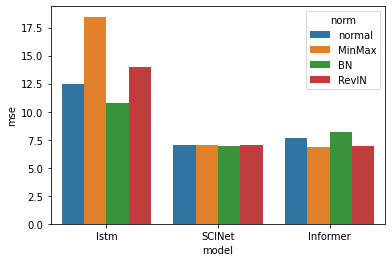

In [26]:
import seaborn as sns
sns.barplot(data = exp[exp.dataset == 'etth1'], x = 'model', y = 'mse', hue = 'norm')

<AxesSubplot:title={'center':'metric : r2'}, xlabel='model', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

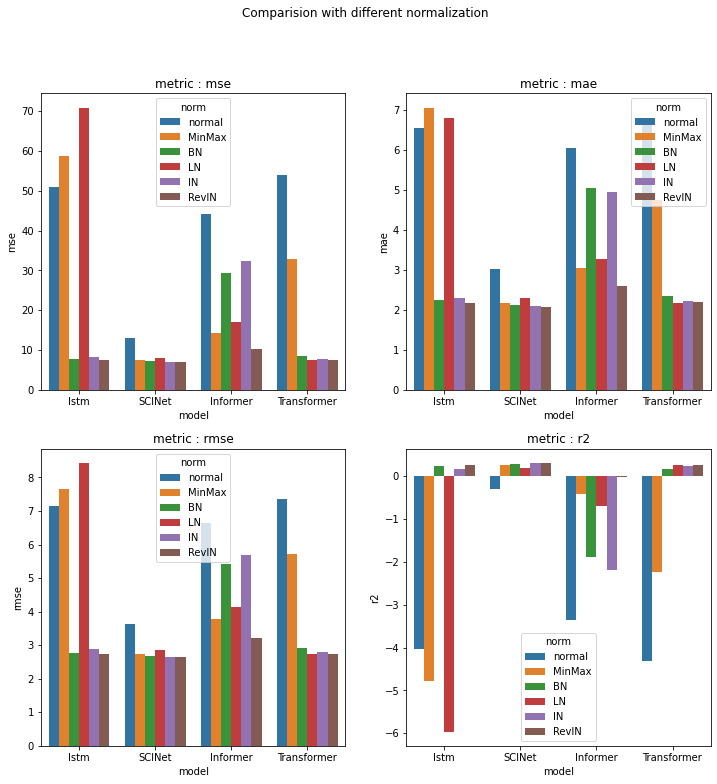

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = False, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
sns.barplot(ax = axes[0,0], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
sns.barplot(ax = axes[1,1], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'r2', hue = 'norm')

<AxesSubplot:title={'center':'metric : r2'}, xlabel='model', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

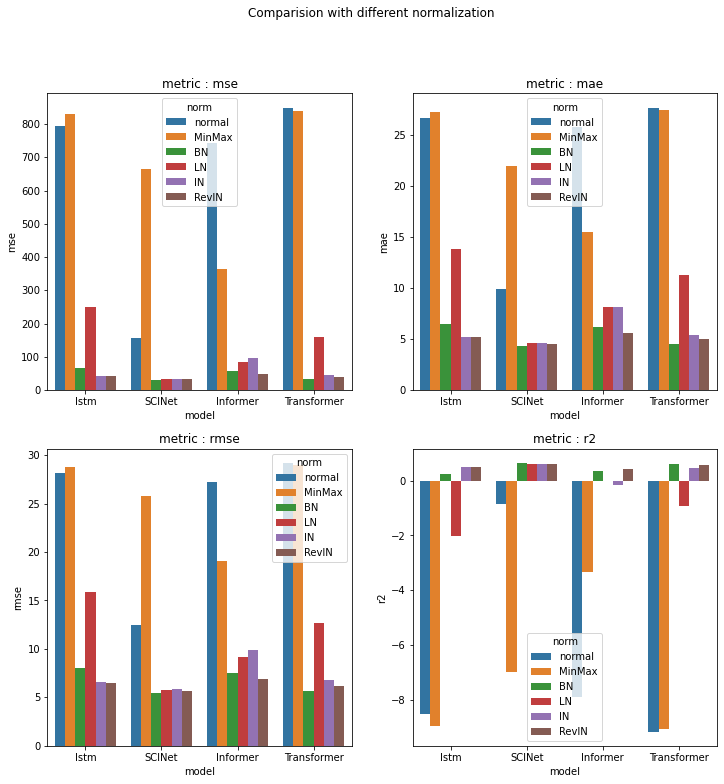

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = False, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
sns.barplot(ax = axes[0,0], data = exp[exp.dataset == 'etth2'], x = 'model', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp[exp.dataset == 'etth2'], x = 'model', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp[exp.dataset == 'etth2'], x = 'model', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
sns.barplot(ax = axes[1,1], data = exp[exp.dataset == 'etth2'], x = 'model', y = 'r2', hue = 'norm')

<AxesSubplot:title={'center':'metric : r2'}, xlabel='model', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

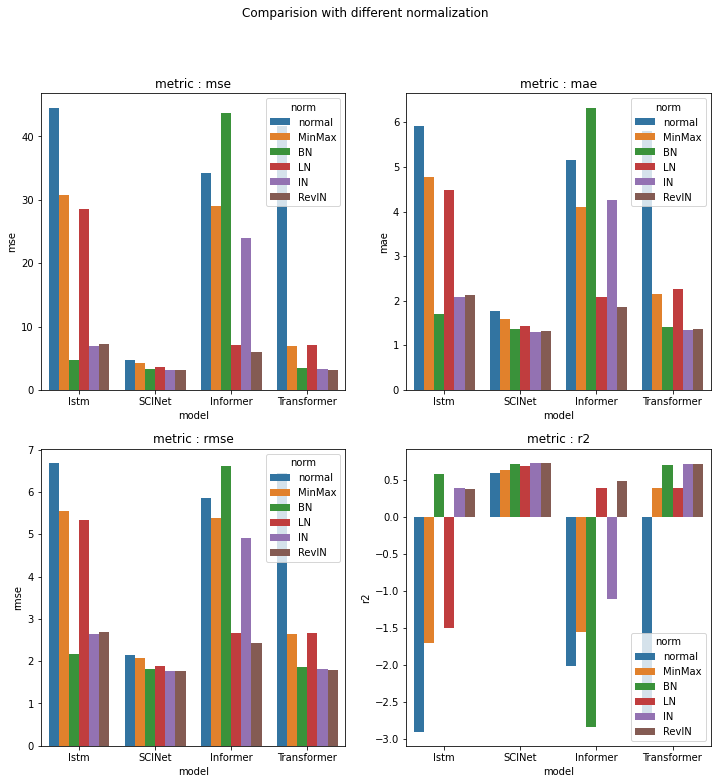

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = False, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
sns.barplot(ax = axes[0,0], data = exp[exp.dataset == 'ettm1'], x = 'model', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp[exp.dataset == 'ettm1'], x = 'model', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp[exp.dataset == 'ettm1'], x = 'model', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
sns.barplot(ax = axes[1,1], data = exp[exp.dataset == 'ettm1'], x = 'model', y = 'r2', hue = 'norm')

<AxesSubplot:title={'center':'metric : r2'}, xlabel='model', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

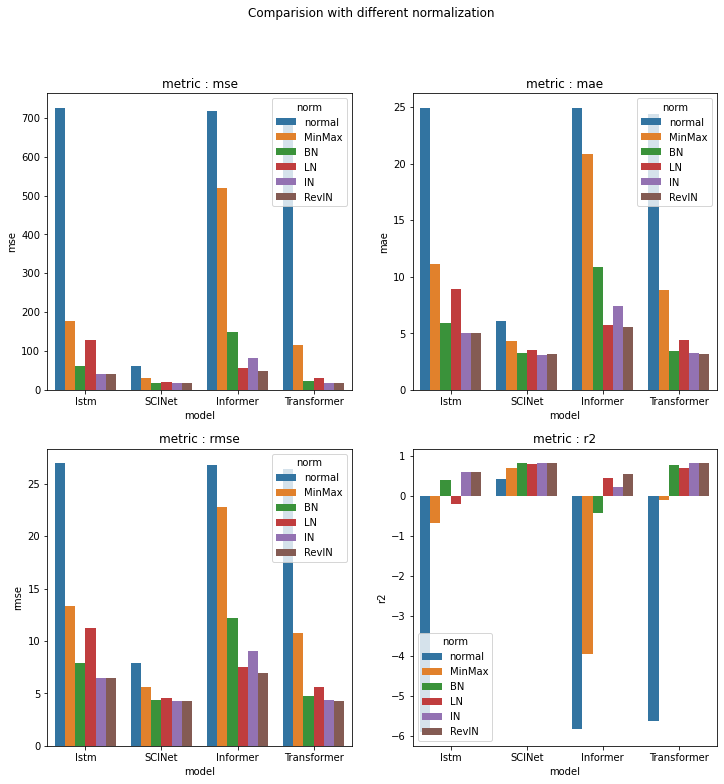

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = False, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
sns.barplot(ax = axes[0,0], data = exp[exp.dataset == 'ettm2'], x = 'model', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp[exp.dataset == 'ettm2'], x = 'model', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp[exp.dataset == 'ettm2'], x = 'model', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
sns.barplot(ax = axes[1,1], data = exp[exp.dataset == 'ettm2'], x = 'model', y = 'r2', hue = 'norm')

<AxesSubplot:title={'center':'metric : r2'}, xlabel='model', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

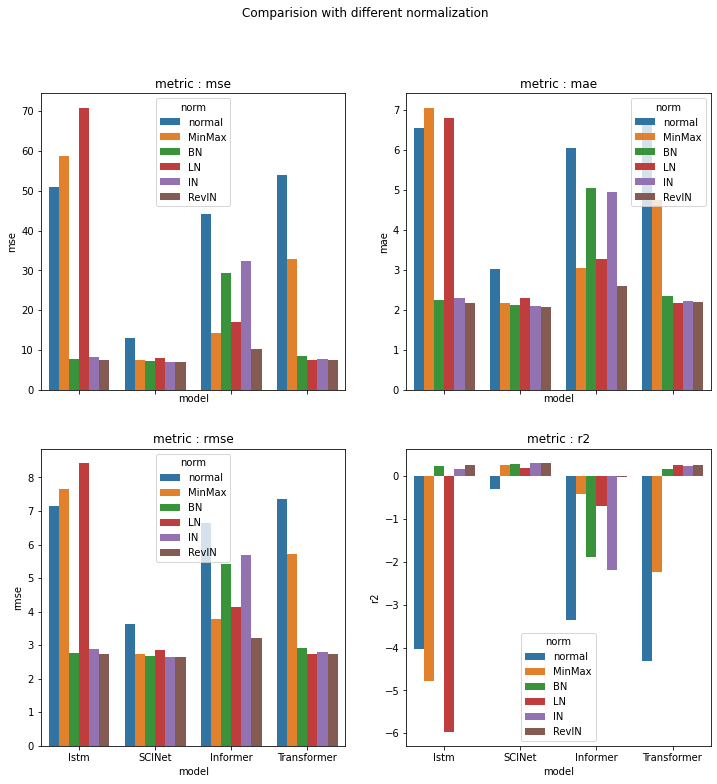

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = True, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
sns.barplot(ax = axes[0,0], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
sns.barplot(ax = axes[1,1], data = exp[exp.dataset == 'etth1'], x = 'model', y = 'r2', hue = 'norm')

In [6]:
exp[exp.dataset == 'ettm1']

,mse,rmse,mae,r2,model,dataset,norm,seq_len,pred_len
0,5.010833,2.238489,1.664665,0.574971,lstm,ettm1,normal,128.0,32.0
0,6.207355,2.491457,1.918350,0.473479,lstm,ettm1,MinMax,128.0,32.0
0,7.253613,2.693253,2.002347,0.384734,lstm,ettm1,BN,128.0,32.0
0,7.575601,2.752381,2.097854,0.357422,lstm,ettm1,LN,128.0,32.0
0,19.280157,4.390918,3.538696,-0.635382,lstm,ettm1,IN,128.0,32.0
0,2.024698,1.422919,0.982256,0.828261,lstm,ettm1,RevIN,128.0,32.0
0,2.262757,1.504246,1.063686,0.808068,SCINet,ettm1,normal,128.0,32.0
0,2.191860,1.480493,1.056039,0.814082,SCINet,ettm1,MinMax,128.0,32.0
0,1.723411,1.312788,0.930868,0.853817,SCINet,ettm1,BN,128.0,32.0
0,11.643626,3.412276,2.756048,0.012364,SCINet,ettm1,LN,128.0,32.0


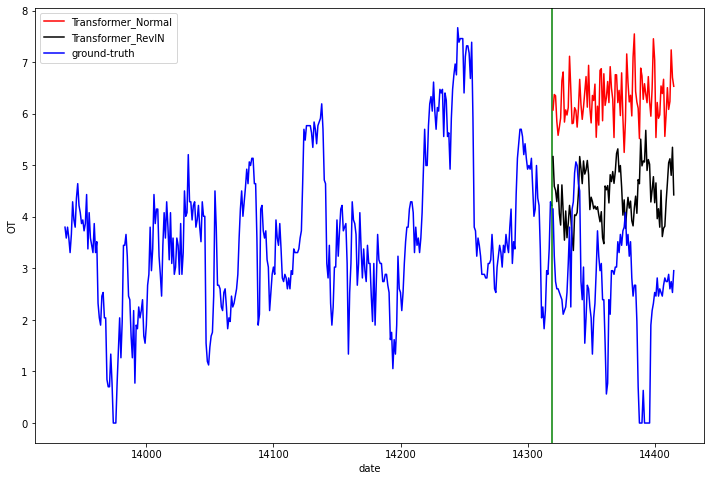

In [12]:
# plot the trend
model_type = 'Transformer'
norms_type = 'RevIN'
dataset = 'etth1'

model, device = load_model(model_type,'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (12,8))
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

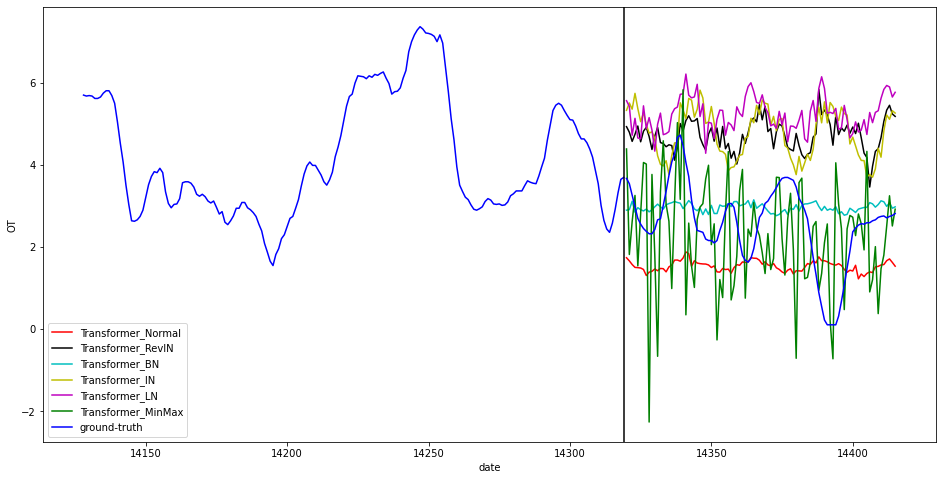

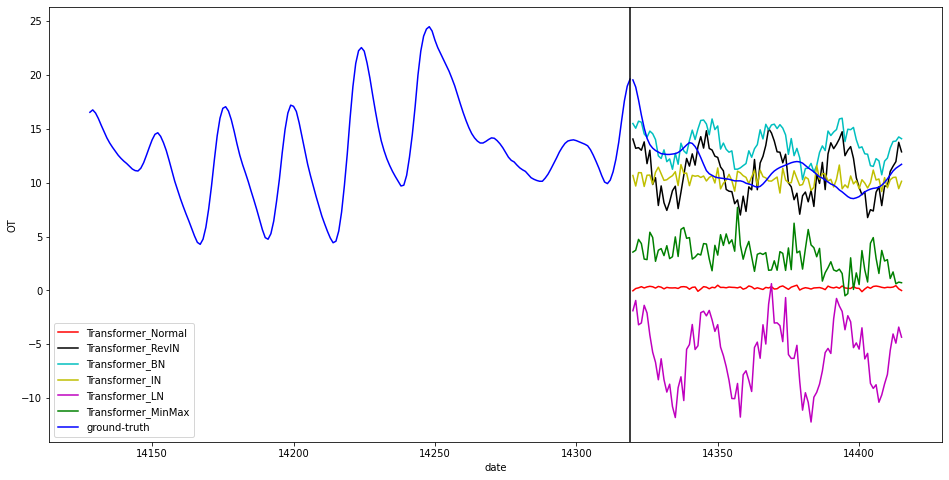

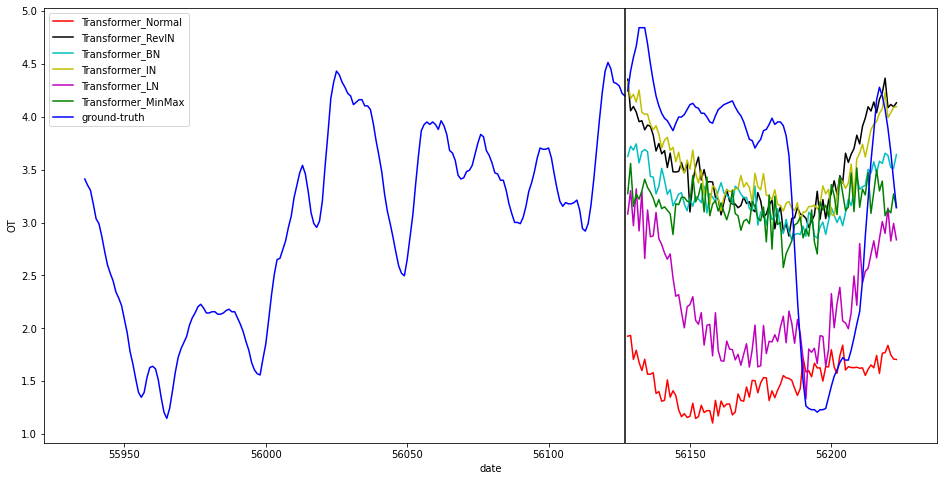

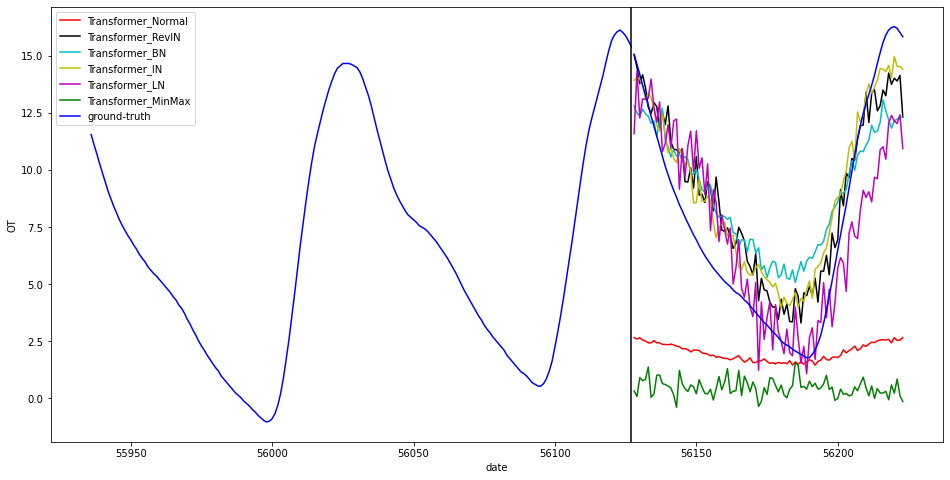

In [59]:
# plot the trend
model_type = 'Transformer'
norms_type = 'RevIN'
dataset = 'etth1'

model, device = load_model(model_type,'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
ts_train, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

# plot the trend
model_type = 'Transformer'
norms_type = 'RevIN'
dataset = 'etth2'

model, device = load_model(model_type,'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
ts_train, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(2, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

# plot the trend
model_type = 'Transformer'
norms_type = 'RevIN'
dataset = 'ettm1'

model, device = load_model(model_type,'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
ts_train, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(3, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

# plot the trend
model_type = 'Transformer'
norms_type = 'RevIN'
dataset = 'ettm2'

model, device = load_model(model_type,'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
ts_train, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(4, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

In [60]:
from torch.utils.data import DataLoader
from src.train import evaluate
exp = pd.DataFrame({
    "mse":[],
    "rmse":[],
    "mae":[],
    "r2":[],
    "model":[],
    "dataset":[],
    "norm":[],
    "seq_len":[],
    "pred_len" :[]
})

# setting
seq_len = 24 * 4 * 4
pred_len = 24 * 4
stride = 4
dist = 0

# experiment setting
norms_list = ['normal','MinMax', 'BN','LN','IN','RevIN']
dataset_list = ['etth1', 'etth2', 'ettm1', 'ettm2']
model_list = ['Transformer']

# analysis
for model_type in model_list:
    for dataset in dataset_list:
        for norms in norms_list:
            data = pd.read_csv(config.DATA_PATH[dataset])
            data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
            _, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)
            
            if model_type == 'Informer':
                test_data = CustomDataset(ts_test, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)
            else:
                test_data = CustomDataset(ts_test, config.src_cols, config.tar_cols, seq_len, pred_len, stride = stride)
                   
            test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
         
            model, device = load_model(model_type, norms, dataset, seq_len, pred_len)
            
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
            loss_fn = torch.nn.MSELoss(reduction='mean')
    
            test_loss, mse, rmse, mae, r2 = evaluate(
                test_loader,
                model,
                model_type.lower(),
                optimizer,
                loss_fn,
                device, 
            )
            
            result = pd.DataFrame({
                "mse":[mse],
                "rmse":[rmse],
                "mae":[mae],
                "r2":[r2],
                "model":[model_type],
                "dataset":[dataset],
                "norm":[norms],
                "seq_len":[seq_len],
                "pred_len" :[pred_len]
            })
            exp = exp.append(result)
            
            model.cpu()
            del model
            del test_loader
            del test_data

test loss : 29.689
# mse:53.950, rmse:7.345, mae:6.664, r2:-4.313
test loss : 27.119
# mse:32.798, rmse:5.727, mae:4.752, r2:-2.230
test loss : 8.363
# mse:8.417, rmse:2.901, mae:2.352, r2:0.171
test loss : 16.944
# mse:7.530, rmse:2.744, mae:2.182, r2:0.259
test loss : 7.595
# mse:7.759, rmse:2.786, mae:2.224, r2:0.236
test loss : 7.651
# mse:7.480, rmse:2.735, mae:2.188, r2:0.263
test loss : 492.763
# mse:849.530, rmse:29.147, mae:27.679, r2:-9.171
test loss : 427.135
# mse:840.427, rmse:28.990, mae:27.418, r2:-9.062
test loss : 12.709
# mse:32.450, rmse:5.696, mae:4.544, r2:0.611
test loss : 125.396
# mse:160.013, rmse:12.650, mae:11.307, r2:-0.916
test loss : 14.991
# mse:46.225, rmse:6.799, mae:5.383, r2:0.447
test loss : 12.555
# mse:37.865, rmse:6.153, mae:4.977, r2:0.547
test loss : 31.149
# mse:41.723, rmse:6.459, mae:5.809, r2:-2.660
test loss : 9.405
# mse:6.925, rmse:2.631, mae:2.148, r2:0.393
test loss : 7.654
# mse:3.460, rmse:1.860, mae:1.412, r2:0.697
test loss : 10.685

<AxesSubplot:title={'center':'metric : r2'}, xlabel='dataset', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

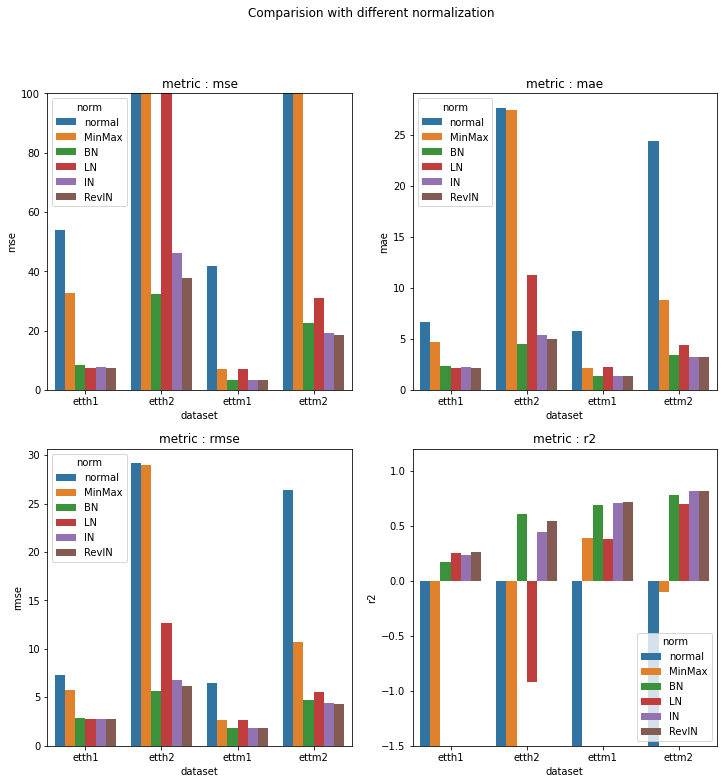

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = False, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
axes[0,0].set_ylim([0, 100])
sns.barplot(ax = axes[0,0], data = exp, x = 'dataset', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp, x = 'dataset', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp, x = 'dataset', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
axes[1,1].set_ylim([-1.5, 1.2])
sns.barplot(ax = axes[1,1], data = exp, x = 'dataset', y = 'r2', hue = 'norm')

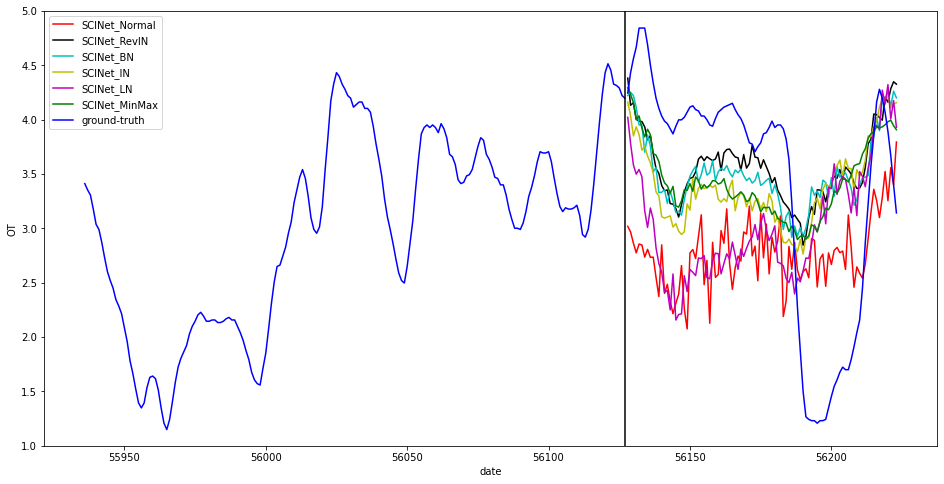

In [25]:
# plot the trend
model_type = 'SCINet'
norms_type = 'RevIN'
dataset = 'ettm1'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.ylim([1.0, 5.0])
plt.show()

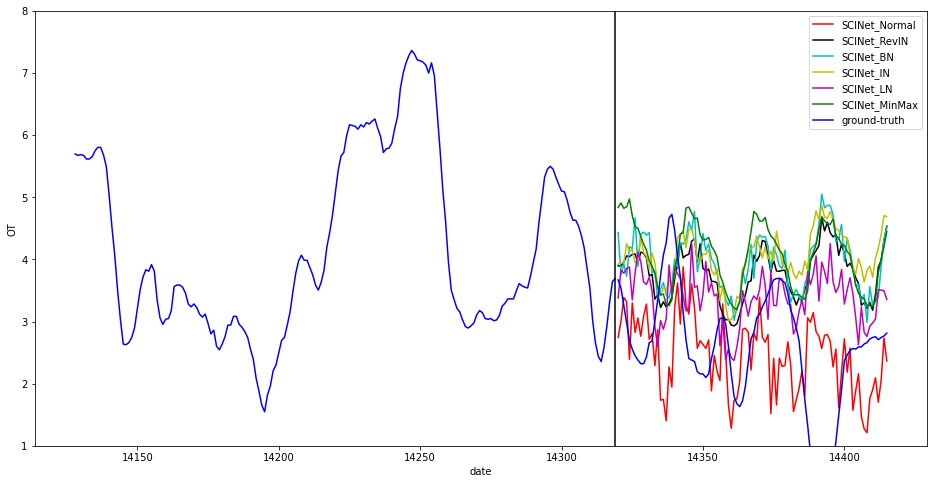

In [48]:
# plot the trend
model_type = 'SCINet'
norms_type = 'RevIN'
dataset = 'etth1'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.ylim([1.0, 8.0])
# plt.yscale("log", base = 10)
plt.show()

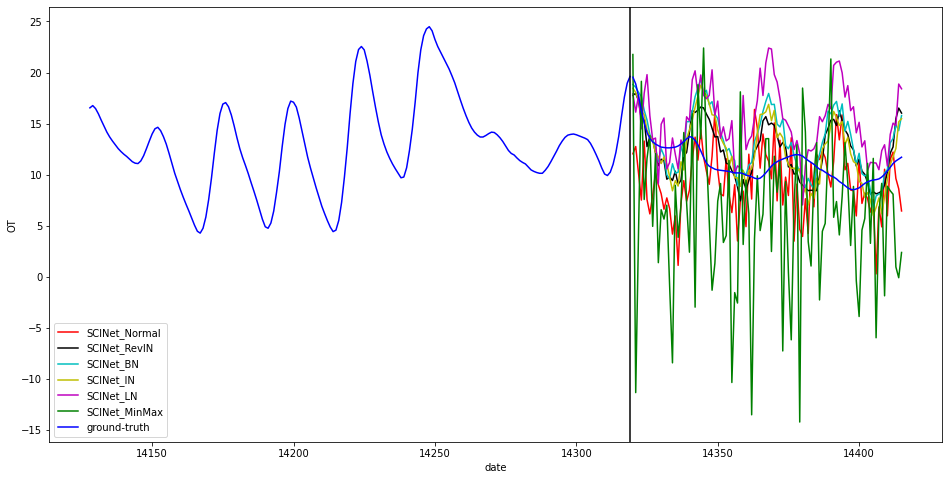

In [52]:
# plot the trend
model_type = 'SCINet'
norms_type = 'RevIN'
dataset = 'etth2'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

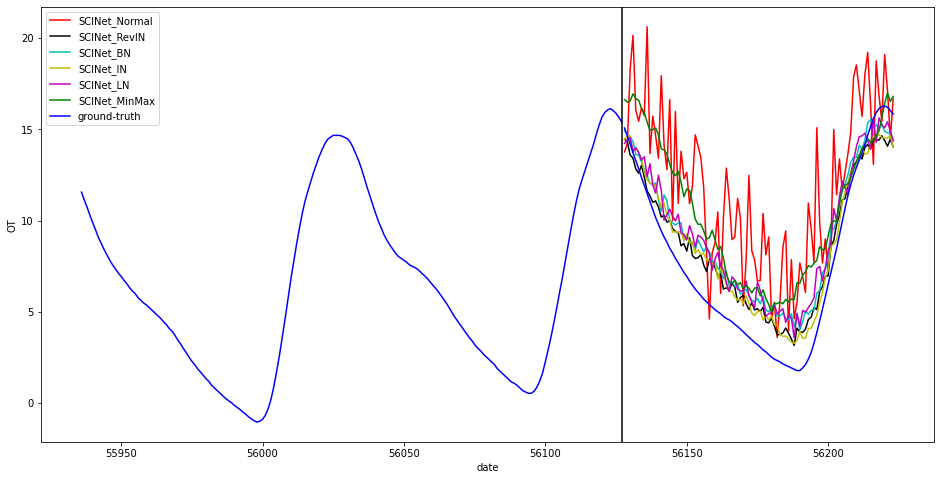

In [50]:
# plot the trend
model_type = 'SCINet'
norms_type = 'RevIN'
dataset = 'ettm2'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
model.eval()
pred_in = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
# plt.ylim([1.0, 8.0])
# plt.yscale("log", base = 10)
plt.show()

In [35]:
from torch.utils.data import DataLoader
from src.train import evaluate
exp = pd.DataFrame({
    "mse":[],
    "rmse":[],
    "mae":[],
    "r2":[],
    "model":[],
    "dataset":[],
    "norm":[],
    "seq_len":[],
    "pred_len" :[]
})

# setting
seq_len = 24 * 4 * 4
pred_len = 24 * 4
stride = 4
dist = 0

# experiment setting
norms_list = ['normal','MinMax', 'BN','LN','IN','RevIN']
dataset_list = ['etth1', 'etth2', 'ettm1', 'ettm2']
model_list = ['SCINet']

# analysis
for model_type in model_list:
    for dataset in dataset_list:
        for norms in norms_list:
            data = pd.read_csv(config.DATA_PATH[dataset])
            data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
            _, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)
            
            if model_type == 'Informer':
                test_data = CustomDataset(ts_test, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)
            else:
                test_data = CustomDataset(ts_test, config.src_cols, config.tar_cols, seq_len, pred_len, stride = stride)
                   
            test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
         
            model, device = load_model(model_type, norms, dataset, seq_len, pred_len)
            
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
            loss_fn = torch.nn.MSELoss(reduction='mean')
    
            test_loss, mse, rmse, mae, r2 = evaluate(
                test_loader,
                model,
                model_type.lower(),
                optimizer,
                loss_fn,
                device, 
            )
            
            result = pd.DataFrame({
                "mse":[mse],
                "rmse":[rmse],
                "mae":[mae],
                "r2":[r2],
                "model":[model_type],
                "dataset":[dataset],
                "norm":[norms],
                "seq_len":[seq_len],
                "pred_len" :[pred_len]
            })
            exp = exp.append(result)
            
            model.cpu()
            del model
            del test_loader
            del test_data

test loss : 9.391
# mse:13.149, rmse:3.626, mae:3.027, r2:-0.295
test loss : 8.276
# mse:7.412, rmse:2.722, mae:2.169, r2:0.270
test loss : 8.023
# mse:7.167, rmse:2.677, mae:2.112, r2:0.294
test loss : 8.512
# mse:8.142, rmse:2.854, mae:2.291, r2:0.198
test loss : 7.953
# mse:7.083, rmse:2.661, mae:2.084, r2:0.302
test loss : 7.826
# mse:6.960, rmse:2.638, mae:2.074, r2:0.315
test loss : 409.077
# mse:154.942, rmse:12.448, mae:9.933, r2:-0.855
test loss : 630.528
# mse:665.992, rmse:25.807, mae:21.951, r2:-6.974
test loss : 9.884
# mse:29.605, rmse:5.441, mae:4.338, r2:0.646
test loss : 15.135
# mse:33.676, rmse:5.803, mae:4.568, r2:0.597
test loss : 10.708
# mse:34.117, rmse:5.841, mae:4.650, r2:0.592
test loss : 11.020
# mse:32.027, rmse:5.659, mae:4.524, r2:0.617
test loss : 8.422
# mse:4.653, rmse:2.157, mae:1.763, r2:0.592
test loss : 8.076
# mse:4.267, rmse:2.066, mae:1.602, r2:0.626
test loss : 7.315
# mse:3.287, rmse:1.813, mae:1.355, r2:0.712
test loss : 7.302
# mse:3.590, rm

<AxesSubplot:title={'center':'metric : r2'}, xlabel='dataset', ylabel='r2'>

<Figure size 432x288 with 0 Axes>

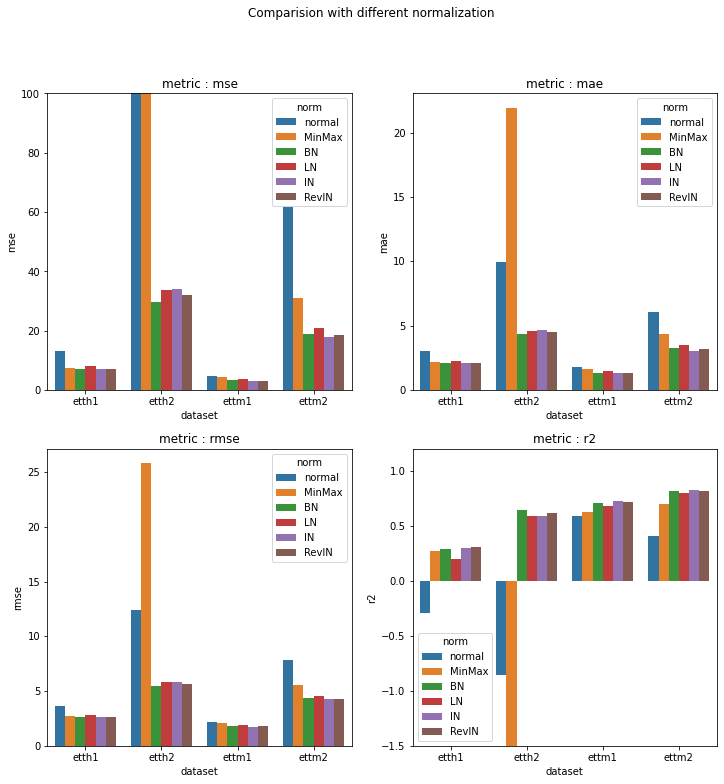

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(1)

fig, axes = plt.subplots(2,2,sharex = False, figsize = (12,12))
fig.suptitle("Comparision with different normalization")
axes[0,0].set_title("metric : mse")
axes[0,0].set_ylim([0, 100])
sns.barplot(ax = axes[0,0], data = exp, x = 'dataset', y = 'mse', hue = 'norm')
axes[1,0].set_title("metric : rmse")
sns.barplot(ax = axes[1,0], data = exp, x = 'dataset', y = 'rmse', hue = 'norm')
axes[0,1].set_title("metric : mae")
sns.barplot(ax = axes[0,1], data = exp, x = 'dataset', y = 'mae', hue = 'norm')
axes[1,1].set_title("metric : r2")
axes[1,1].set_ylim([-1.5, 1.2])
sns.barplot(ax = axes[1,1], data = exp, x = 'dataset', y = 'r2', hue = 'norm')

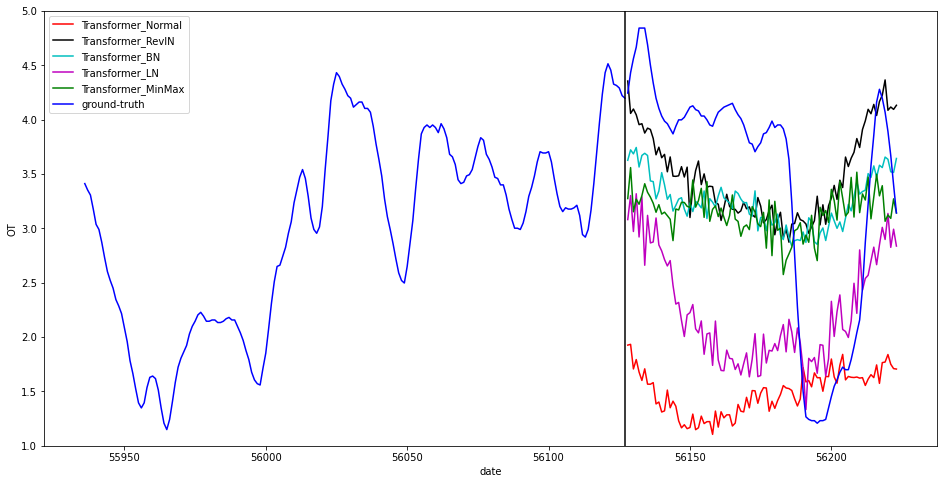

In [19]:
# plot the trend - Transformer
model_type = 'Transformer'
norms_type = 'RevIN'
dataset = 'ettm1'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

# model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
# model.eval()
# pred_in = model.predict(test_input, output_len).squeeze(0)
# model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
# plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.ylim([1.0, 5.0])
plt.show()

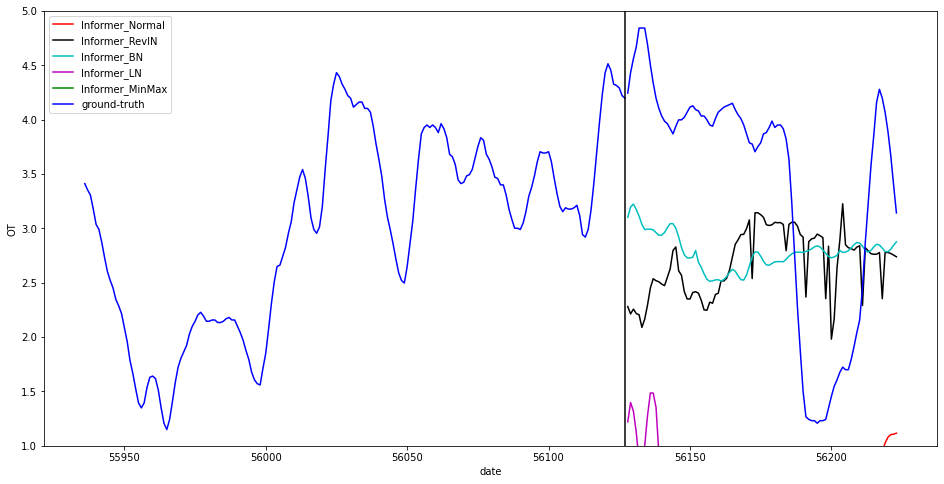

In [15]:
# plot the trend - Informer
model_type = 'Informer'
norms_type = 'RevIN'
dataset = 'ettm1'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.t_feature_cols + config.src_cols
tar_cols = config.t_feature_cols + config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

# model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
# model.eval()
# pred_in = model.predict(test_input, output_len).squeeze(0)
# model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
# plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.ylim([1.0, 5.0])
plt.show()

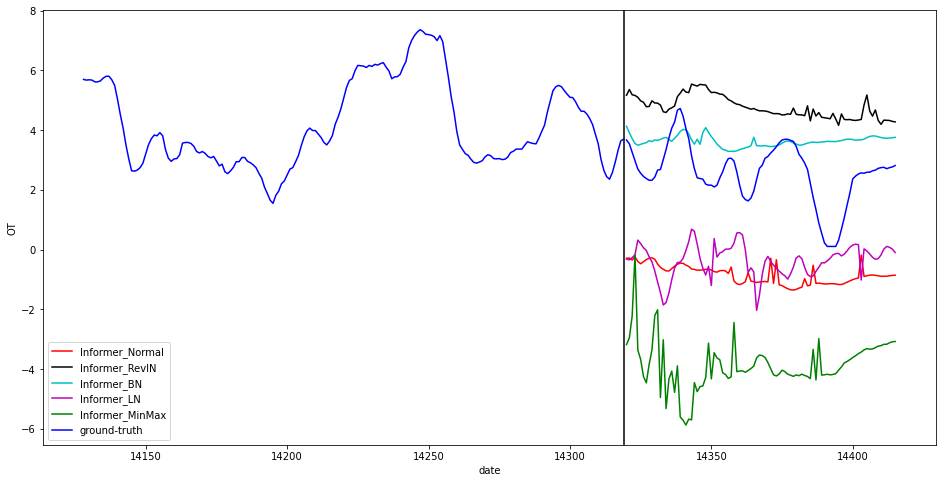

In [24]:
# plot the trend - Informer
model_type = 'Informer'
norms_type = 'RevIN'
dataset = 'etth1'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.t_feature_cols + config.src_cols
tar_cols = config.t_feature_cols + config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

# model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
# model.eval()
# pred_in = model.predict(test_input, output_len).squeeze(0)
# model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
# plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

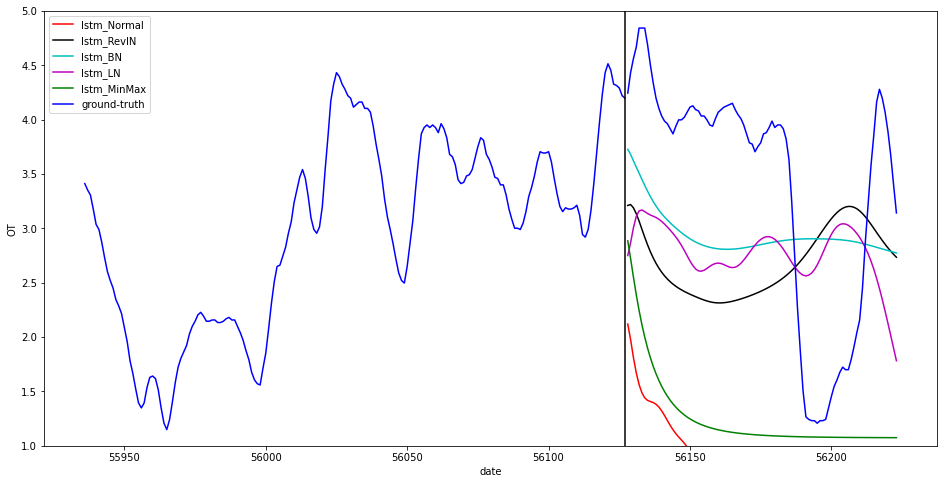

In [21]:
# plot the trend - LSTM
model_type = 'lstm'
norms_type = 'RevIN'
dataset = 'ettm1'

model, device = load_model(model_type, 'normal',dataset, seq_len, pred_len)

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
# _, _, ts_test, scaling = split_data(data, 0.6, 0.2, config.src_cols, 'Standard')
_, _, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)

input_len = seq_len
output_len = pred_len
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

src_cols = config.src_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
model.eval()
pred_revin = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'BN', dataset, seq_len, pred_len)
model.eval()
pred_bn = model.predict(test_input, output_len).squeeze(0)
model.cpu()

# model, device = load_model(model_type, 'IN', dataset, seq_len, pred_len)
# model.eval()
# pred_in = model.predict(test_input, output_len).squeeze(0)
# model.cpu()

model, device = load_model(model_type, 'MinMax', dataset, seq_len, pred_len)
model.eval()
pred_minmax = model.predict(test_input, output_len).squeeze(0)
model.cpu()

model, device = load_model(model_type, 'LN', dataset, seq_len, pred_len)
model.eval()
pred_ln = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,8))
plt.plot(tx_input[seq_len//2:], ts_test[src_cols].iloc[idx_srt : idx_end].values[seq_len//2:, col_idx], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'k')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, 'Normal'))
plt.plot(tx_output, pred_revin[:,col_idx].cpu().numpy(), c = 'k', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, pred_bn[:,col_idx].cpu().numpy(), c = 'c', label = "{}_{}".format(model_type, "BN"))
# plt.plot(tx_output, pred_in[:,col_idx].cpu().numpy(), c = 'y', label = "{}_{}".format(model_type, "IN"))
plt.plot(tx_output, pred_ln[:,col_idx].cpu().numpy(), c = 'm', label = "{}_{}".format(model_type, "LN"))
plt.plot(tx_output, pred_minmax[:,col_idx].cpu().numpy(), c = 'g', label = "{}_{}".format(model_type, "MinMax"))

plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.ylim([1.0, 5.0])
plt.show()

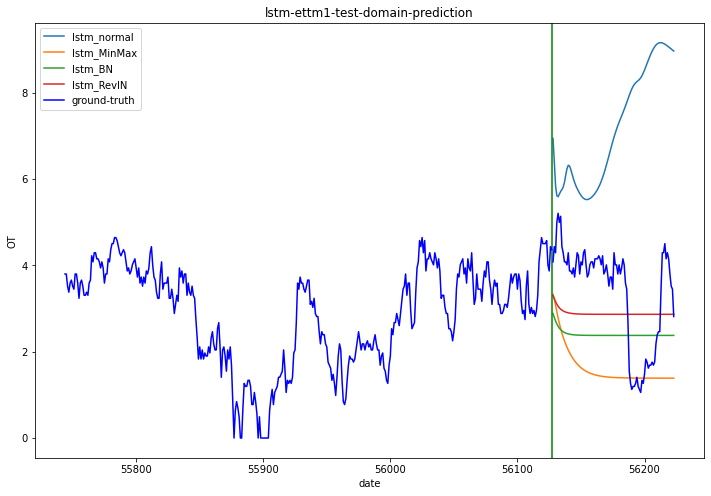

In [21]:
# model performace, LSTM seq2seq
model_type = 'lstm'
dataset = 'ettm1'

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
_, _, ts_test = split_data(data, 0.6, 0.2)

plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    # src_cols = config.t_feature_cols + config.src_cols
    src_cols = config.src_cols
    # tar_cols = config.t_feature_cols + config.tar_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    model.eval()
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

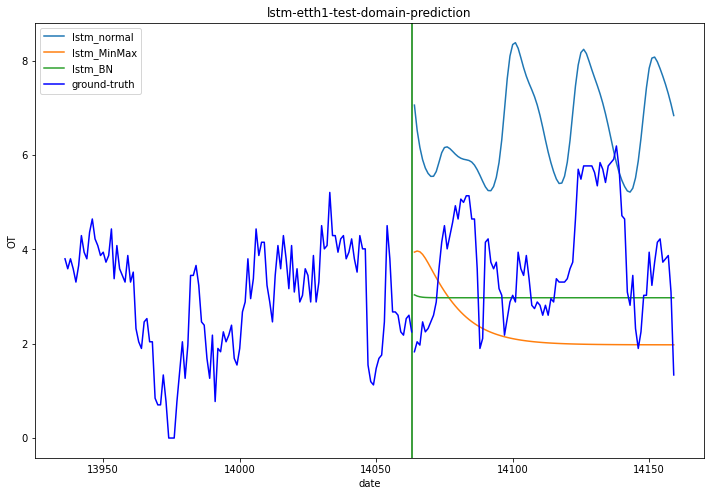

In [16]:
# model performace, LSTM seq2seq
import matplotlib.pyplot as plt
model_type = 'lstm'
dataset = 'etth1'

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
_, _, ts_test = split_data(data, 0.6, 0.2)

plt.figure(1, figsize = (12,8))

for norms_type in ["normal", "MinMax", "BN"]:
    model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    # src_cols = config.t_feature_cols + config.src_cols
    src_cols = config.src_cols
    # tar_cols = config.t_feature_cols + config.tar_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    model.eval()
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

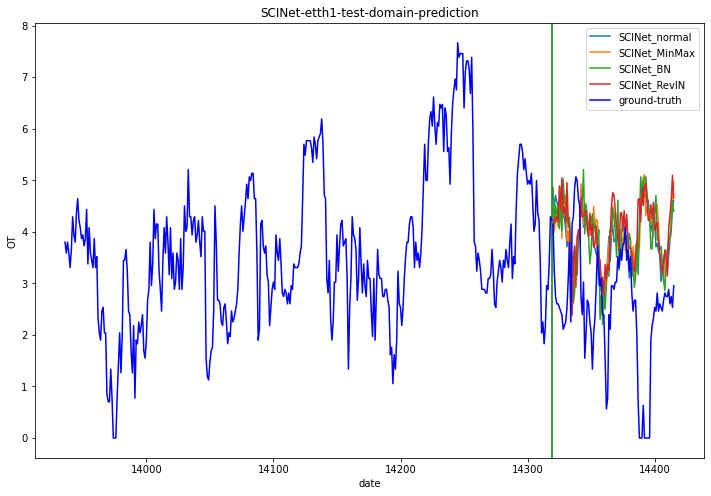

In [7]:
# model performace, SCINet
model_type = 'SCINet'
dataset = 'etth1'

norms_list = ['normal','MinMax', 'BN', 'RevIN']

data = pd.read_csv(config.DATA_PATH[dataset])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
_, _, ts_test = split_data(data, 0.6, 0.2)

plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    # src_cols = config.t_feature_cols + config.src_cols
    src_cols = config.src_cols
    # tar_cols = config.t_feature_cols + config.tar_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    model.eval()
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

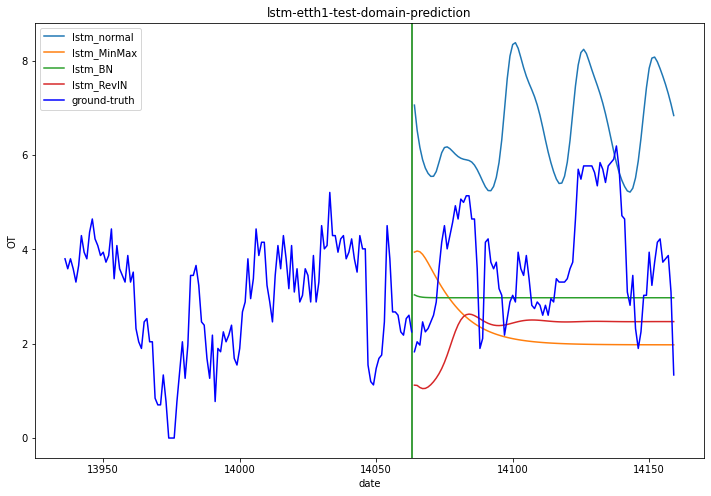

In [47]:
# model performace, LSTM seq2seq
model_type = 'lstm'
dataset = 'etth1'
pred_len = 24 * 4
plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    src_cols = config.src_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()
    
    

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

In [48]:
# model performace, LSTM seq2seq
from torch.utils.data import DataLoader
from src.utils import compute_metrics
from src.train import evaluate

model_type = 'lstm'
dataset = 'etth1'
seq_len = 128

exp_pred_len = {
    "r2":[],
    "mse":[],
    "rmse":[],
    "mae":[],
    "pred_len":[],
    'norms':[]
}

for pred_len in [16, 32, 64, 96, 128]:
    for norms_type in norms_list:
        
        data = pd.read_csv(config.DATA_PATH[dataset])
        data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
        _,_,ts_test = split_data(data, 0.6, 0.2)
        
        src_cols = config.src_cols
        tar_cols = config.tar_cols
        
        test_data = CustomDataset(ts_test, src_cols, tar_cols, seq_len, pred_len, stride = stride)
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
        
        test_loss, mse, rmse, mae, r2 = evaluate(
            test_loader,
            model,
            'lstm',
            optimizer,
            loss_fn,
            device, 
        )
        
        exp_pred_len['r2'].append(r2)
        exp_pred_len['mse'].append(mse)
        exp_pred_len['rmse'].append(rmse)
        exp_pred_len['mae'].append(mae)
        exp_pred_len['pred_len'].append(pred_len)
        exp_pred_len['norms'].append(norms_type)
        
exp_pred_len = pd.DataFrame(exp_pred_len)

test loss : 14.004
# mse:7.392, rmse:2.719, mae:2.094, r2:0.350
test loss : 22.869
# mse:6.835, rmse:2.614, mae:2.105, r2:0.399
test loss : 24.700
# mse:11.129, rmse:3.336, mae:2.789, r2:0.021
test loss : 11.387
# mse:5.227, rmse:2.286, mae:1.793, r2:0.540
test loss : 14.696
# mse:9.559, rmse:3.092, mae:2.381, r2:0.159
test loss : 24.270
# mse:10.736, rmse:3.277, mae:2.631, r2:0.056
test loss : 24.835
# mse:11.299, rmse:3.361, mae:2.811, r2:0.006
test loss : 14.965
# mse:7.657, rmse:2.767, mae:2.183, r2:0.327
test loss : 16.723
# mse:12.120, rmse:3.481, mae:2.691, r2:-0.067
test loss : 25.620
# mse:14.938, rmse:3.865, mae:3.124, r2:-0.315
test loss : 24.577
# mse:11.330, rmse:3.366, mae:2.819, r2:0.003
test loss : 19.656
# mse:9.372, rmse:3.061, mae:2.427, r2:0.175
test loss : 17.491
# mse:13.619, rmse:3.690, mae:2.840, r2:-0.197
test loss : 26.076
# mse:16.799, rmse:4.099, mae:3.325, r2:-0.477
test loss : 24.636
# mse:11.339, rmse:3.367, mae:2.816, r2:0.003
test loss : 21.601
# mse:10

In [27]:
exp_pred_len[exp_pred_len['norms'] == 'RevIN']

,r2,mse,rmse,mae,pred_len,norms
5,0.580815,4.764800,2.182842,1.701271,16,RevIN
11,0.342552,7.475283,2.734096,2.165641,32,RevIN
17,0.014966,11.188836,3.344972,2.644949,64,RevIN
23,-0.204772,13.705498,3.702094,2.912602,96,RevIN
29,-0.371295,15.602152,3.949956,3.117388,128,RevIN


In [28]:
exp_pred_len[exp_pred_len['norms'] == 'normal']

,r2,mse,rmse,mae,pred_len,norms
0,0.349673,7.392158,2.718852,2.094278,16,normal
6,0.159329,9.558556,3.091691,2.380732,32,normal
12,-0.067038,12.120308,3.481423,2.690572,64,normal
18,-0.197196,13.619315,3.690436,2.840464,96,normal
24,-0.285248,14.623132,3.824020,2.934741,128,normal


In [29]:
exp_pred_len[exp_pred_len['norms'] == 'MinMax']

,r2,mse,rmse,mae,pred_len,norms
1,0.398693,6.834953,2.614374,2.105331,16,MinMax
7,0.055732,10.736468,3.276655,2.631135,32,MinMax
13,-0.315099,14.937989,3.864969,3.123650,64,MinMax
19,-0.476723,16.799217,4.098685,3.324812,96,MinMax
25,-0.570563,17.869350,4.227215,3.438821,128,MinMax


In [30]:
exp_pred_len[exp_pred_len['norms'] == 'BN']

,r2,mse,rmse,mae,pred_len,norms
2,0.189179,9.216458,3.035862,2.448977,16,BN
8,0.101216,10.219312,3.196766,2.633636,32,BN
14,0.036484,10.944414,3.308234,2.758805,64,BN
20,0.014465,11.211451,3.348351,2.803108,96,BN
26,0.002330,11.351170,3.369150,2.825933,128,BN


In [31]:
exp_pred_len[exp_pred_len['norms'] == 'LN']

,r2,mse,rmse,mae,pred_len,norms
3,-2.093448,35.162678,5.929812,4.747753,16,LN
9,-1.978715,33.868446,5.819660,4.620343,32,LN
15,-2.146213,35.737312,5.978069,4.718379,64,LN
21,-2.307224,37.623013,6.133760,4.832326,96,LN
27,-2.386450,38.529922,6.207248,4.899298,128,LN


In [33]:
# model performace, LSTM seq2seq
from torch.utils.data import DataLoader
from src.utils import compute_metrics
from src.train import evaluate

model_type = 'lstm'
dataset = 'etth2'
seq_len = 128

exp_pred_len = {
    "r2":[],
    "mse":[],
    "rmse":[],
    "mae":[],
    "pred_len":[],
    'norms':[]
}

for pred_len in [16, 32, 64, 96, 128]:
    for norms_type in norms_list:
        
        data = pd.read_csv(config.DATA_PATH[dataset])
        data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
        _,_,ts_test = split_data(data, 0.6, 0.2)
        
        src_cols = config.src_cols
        tar_cols = config.tar_cols
        
        test_data = CustomDataset(ts_test, src_cols, tar_cols, seq_len, pred_len, stride = stride)
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
        
        test_loss, mse, rmse, mae, r2 = evaluate(
            test_loader,
            model,
            'lstm',
            optimizer,
            loss_fn,
            device, 
        )
        
        exp_pred_len['r2'].append(r2)
        exp_pred_len['mse'].append(mse)
        exp_pred_len['rmse'].append(rmse)
        exp_pred_len['mae'].append(mae)
        exp_pred_len['pred_len'].append(pred_len)
        exp_pred_len['norms'].append(norms_type)
        
exp_pred_len = pd.DataFrame(exp_pred_len)

test loss : 59.468
# mse:97.555, rmse:9.877, mae:8.013, r2:0.055
test loss : 42.414
# mse:62.002, rmse:7.874, mae:6.368, r2:0.399
test loss : 60.068
# mse:105.485, rmse:10.271, mae:8.577, r2:-0.022
test loss : 2345.165
# mse:1854.499, rmse:43.064, mae:32.832, r2:-16.971
test loss : 60.496
# mse:102.952, rmse:10.147, mae:8.341, r2:0.002
test loss : 15.251
# mse:43.755, rmse:6.615, mae:5.187, r2:0.576
test loss : 60.072
# mse:96.544, rmse:9.826, mae:7.977, r2:0.055
test loss : 40.694
# mse:59.035, rmse:7.683, mae:6.201, r2:0.422
test loss : 60.795
# mse:103.930, rmse:10.195, mae:8.553, r2:-0.017
test loss : 2355.309
# mse:1873.999, rmse:43.290, mae:32.944, r2:-17.334
test loss : 59.592
# mse:102.943, rmse:10.146, mae:8.347, r2:-0.007
test loss : 16.590
# mse:46.624, rmse:6.828, mae:5.379, r2:0.544
test loss : 58.834
# mse:94.113, rmse:9.701, mae:7.899, r2:0.064
test loss : 39.460
# mse:59.173, rmse:7.692, mae:6.226, r2:0.411
test loss : 61.043
# mse:101.928, rmse:10.096, mae:8.491, r2:-0

In [34]:
exp_pred_len[exp_pred_len['norms'] == 'BN']

,r2,mse,rmse,mae,pred_len,norms
2,-0.022213,105.484749,10.270576,8.577396,16,BN
8,-0.016799,103.929520,10.194583,8.552792,32,BN
14,-0.014192,101.928375,10.095959,8.490543,64,BN
20,-0.013753,100.996468,10.049700,8.453195,96,BN
26,-0.014249,100.335678,10.016769,8.426069,128,BN


In [35]:
exp_pred_len[exp_pred_len['norms'] == 'RevIN']

,r2,mse,rmse,mae,pred_len,norms
5,0.575986,43.755062,6.614761,5.187218,16,RevIN
11,0.543856,46.623619,6.828149,5.379117,32,RevIN
17,0.491262,51.129250,7.150472,5.678169,64,RevIN
23,0.460452,53.753170,7.331656,5.850440,96,RevIN
29,0.443662,55.036327,7.418647,5.920354,128,RevIN


In [36]:
exp_pred_len[exp_pred_len['norms'] == 'normal']

,r2,mse,rmse,mae,pred_len,norms
0,0.054629,97.555283,9.877007,8.013186,16,normal
6,0.055454,96.544327,9.825697,7.976964,32,normal
12,0.063576,94.112526,9.701161,7.899107,64,normal
18,0.067487,92.902847,9.638613,7.867424,96,normal
24,0.065411,92.455238,9.615365,7.859456,128,normal


In [63]:
# data shift issue
data = pd.read_csv(config.DATA_PATH["etth1"])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
ts_train, ts_valid, ts_test = split_data(data, 0.6, 0.2)

In [64]:
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.6:
        tag_list.append("train")
    elif idx<= len(data) * 0.8:
        tag_list.append("valid")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

<AxesSubplot:xlabel='OT', ylabel='Density'>

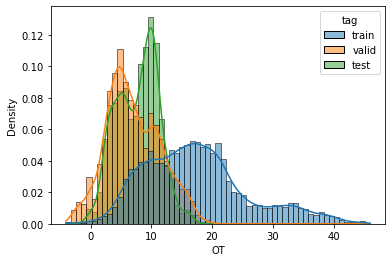

In [65]:
import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

<AxesSubplot:xlabel='OT', ylabel='Density'>

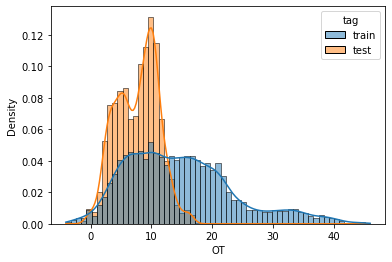

In [14]:
# data shift issue
data = pd.read_csv(config.DATA_PATH["etth1"])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
ts_train, ts_valid, ts_test = split_data(data, 0.6, 0.2, config.src_cols, None)

tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

In [126]:
model_type = 'lstm'
norms_type = 'RevIN'
dataset = 'etth1'
seq_len = 128

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

<AxesSubplot:xlabel='OT', ylabel='Density'>

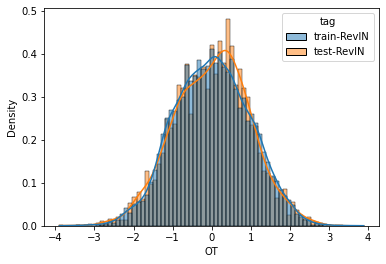

In [127]:
sns.histplot(data = data[(data['tag'] == 'train-RevIN') | (data['tag'] == 'test-RevIN' )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

<AxesSubplot:xlabel='OT', ylabel='Density'>

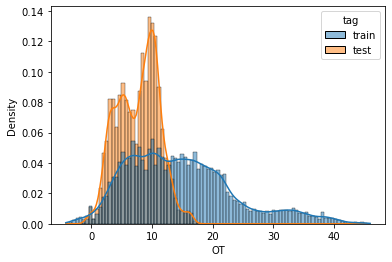

In [115]:
# data shift issue
data = pd.read_csv(config.DATA_PATH["ettm1"])[config.src_cols]
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

In [116]:
model_type = 'lstm'
norms_type = 'RevIN'
dataset = 'ettm1'
seq_len = 128

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

Wrapper(
  (model): SimpleRNN(
    (encoder): RnnEncoder(
      (lstm): LSTM(7, 128, bidirectional=True)
    )
    (decoder): RnnDecoder(
      (lstm): LSTM(7, 128, bidirectional=True)
      (mlp): Linear(in_features=256, out_features=7, bias=True)
    )
  )
  (scaler): RevIN()
)

In [121]:
class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

<AxesSubplot:xlabel='OT', ylabel='Density'>

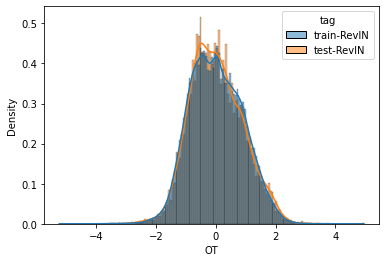

In [123]:
sns.histplot(data = data[(data['tag'] == 'train-RevIN') | (data['tag'] == 'test-RevIN' )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

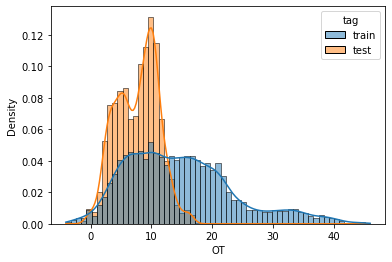

In [9]:
model_type = 'lstm'
norms_type = 'MinMax'
dataset = 'etth1'
seq_len = 128

data = pd.read_csv(config.DATA_PATH[dataset])[config.src_cols]
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

<AxesSubplot:xlabel='OT', ylabel='Density'>

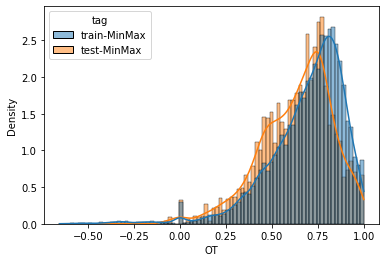

In [10]:
sns.histplot(data = data[(data['tag'] == 'train-MinMax') | (data['tag'] == 'test-MinMax' )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

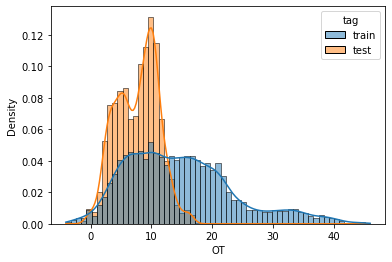

In [11]:
model_type = 'lstm'
norms_type = 'BN'
dataset = 'etth1'
seq_len = 128

data = pd.read_csv(config.DATA_PATH[dataset])[config.src_cols]
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

<AxesSubplot:xlabel='OT', ylabel='Density'>

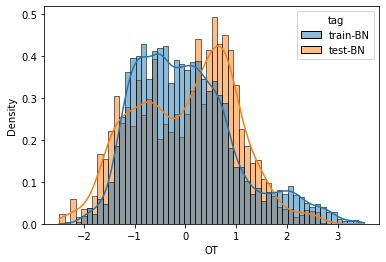

In [12]:
sns.histplot(data = data[(data['tag'] == 'train-{}'.format(norms_type)) | (data['tag'] == 'test-{}'.format(norms_type) )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

<AxesSubplot:xlabel='OT', ylabel='Density'>

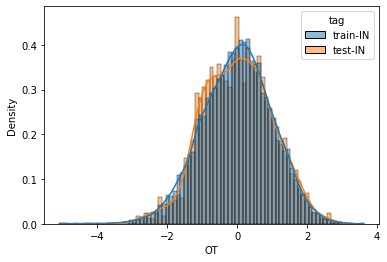

In [16]:
model_type = 'lstm'
norms_type = 'IN'
dataset = 'etth1'
seq_len = 24 * 4 * 4

data = pd.read_csv(config.DATA_PATH[dataset])[config.src_cols]
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

import seaborn as sns

class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

sns.histplot(data = data[(data['tag'] == 'train-{}'.format(norms_type)) | (data['tag'] == 'test-{}'.format(norms_type) )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

<AxesSubplot:xlabel='OT', ylabel='Density'>

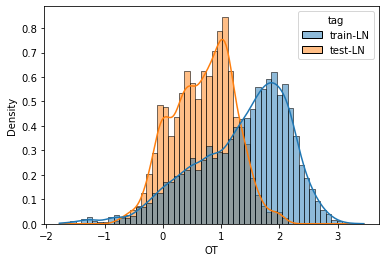

In [17]:
model_type = 'lstm'
norms_type = 'LN'
dataset = 'etth1'
seq_len = 24 * 4 * 4

data = pd.read_csv(config.DATA_PATH[dataset])[config.src_cols]
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

import seaborn as sns

class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-{}'.format(norms_type) for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

sns.histplot(data = data[(data['tag'] == 'train-{}'.format(norms_type)) | (data['tag'] == 'test-{}'.format(norms_type) )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

In [21]:
# model performace, LSTM seq2seq
from torch.utils.data import DataLoader
from src.utils import compute_metrics
from src.train import evaluate

model_type = 'lstm'
dataset = 'etth1'
seq_len = 24 * 4 * 4

exp_pred_len = {
    "r2":[],
    "mse":[],
    "rmse":[],
    "mae":[],
    "pred_len":[],
    'norms':[]
}

for pred_len in [24, 24 * 2, 24 * 3, 24 * 4, 24 * 5]:
    for norms_type in norms_list:
        
        data = pd.read_csv(config.DATA_PATH[dataset])
        data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
        _,_,ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)
        
        src_cols = config.src_cols
        tar_cols = config.tar_cols
        
        test_data = CustomDataset(ts_test, src_cols, tar_cols, seq_len, pred_len, stride = stride)
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
        
        test_loss, mse, rmse, mae, r2 = evaluate(
            test_loader,
            model,
            'lstm',
            optimizer,
            loss_fn,
            device, 
        )
        
        exp_pred_len['r2'].append(r2)
        exp_pred_len['mse'].append(mse)
        exp_pred_len['rmse'].append(rmse)
        exp_pred_len['mae'].append(mae)
        exp_pred_len['pred_len'].append(pred_len)
        exp_pred_len['norms'].append(norms_type)
        
exp_pred_len = pd.DataFrame(exp_pred_len)

test loss : 31.290
# mse:50.190, rmse:7.084, mae:6.498, r2:-3.864
test loss : 31.387
# mse:57.532, rmse:7.585, mae:6.962, r2:-4.576
test loss : 9.956
# mse:3.947, rmse:1.987, mae:1.586, r2:0.617
test loss : 26.532
# mse:18.867, rmse:4.344, mae:3.577, r2:-0.829
test loss : 9.767
# mse:5.934, rmse:2.436, mae:1.940, r2:0.425
test loss : 7.286
# mse:6.112, rmse:2.472, mae:1.969, r2:0.408
test loss : 29.811
# mse:49.918, rmse:7.065, mae:6.476, r2:-3.859
test loss : 31.638
# mse:58.057, rmse:7.620, mae:6.997, r2:-4.651
test loss : 10.813
# mse:5.487, rmse:2.342, mae:1.884, r2:0.466
test loss : 34.318
# mse:43.218, rmse:6.574, mae:5.311, r2:-3.207
test loss : 10.605
# mse:7.266, rmse:2.696, mae:2.140, r2:0.293
test loss : 9.401
# mse:6.680, rmse:2.585, mae:2.066, r2:0.350
test loss : 30.097
# mse:50.285, rmse:7.091, mae:6.500, r2:-3.917
test loss : 31.768
# mse:58.405, rmse:7.642, mae:7.022, r2:-4.711
test loss : 11.517
# mse:6.761, rmse:2.600, mae:2.101, r2:0.339
test loss : 38.950
# mse:60.

In [22]:
exp_pred_len[exp_pred_len['norms'] == 'RevIN']

,r2,mse,rmse,mae,pred_len,norms
5,0.407675,6.111598,2.472165,1.968936,24,RevIN
11,0.349752,6.680410,2.584649,2.066121,48,RevIN
17,0.306467,7.092456,2.663167,2.130669,72,RevIN
23,0.268528,7.427999,2.725435,2.181772,96,RevIN
29,0.236108,7.706872,2.776125,2.223958,120,RevIN


In [23]:
exp_pred_len[exp_pred_len['norms'] == 'BN']

,r2,mse,rmse,mae,pred_len,norms
2,0.617424,3.947411,1.986809,1.585775,24,BN
8,0.465911,5.487036,2.342442,1.883836,48,BN
14,0.338868,6.761107,2.600213,2.101280,72,BN
20,0.237081,7.747343,2.783405,2.259671,96,BN
26,0.162203,8.452493,2.907317,2.367565,120,BN


In [24]:
exp_pred_len[exp_pred_len['norms'] == 'IN']

,r2,mse,rmse,mae,pred_len,norms
4,0.424911,5.933759,2.435931,1.940239,24,IN
10,0.292736,7.266181,2.695585,2.139807,48,IN
16,0.224303,7.932711,2.816507,2.233004,72,IN
22,0.177804,8.349292,2.889514,2.288211,96,IN
28,0.142748,8.648774,2.940880,2.328641,120,IN


In [21]:
# model performace, LSTM seq2seq
from torch.utils.data import DataLoader
from src.utils import compute_metrics
from src.train import evaluate

model_type = 'Transformer'
dataset = 'etth1'
seq_len = 24 * 5
pred_len = 24

exp_pred_len = {
    "r2":[],
    "mse":[],
    "rmse":[],
    "mae":[],
    "pred_len":[],
    'norms':[]
}

def evaluate_scinet(
    test_loader : DataLoader, 
    model : torch.nn.Module,
    loss_fn : torch.nn.Module,
    device : str = "cpu",
    scaling = None,
    pred_len : int = 24
    ):

    model.eval()
    model.to(device)
    test_loss = 0
    
    pts = []
    gts = []

    for batch_idx, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            optimizer.zero_grad()
            data = data.to(device)
            target = target.to(device)
            target_len = target.size()[1]
            
            output = torch.zeros((target.size()[0], data.size()[1] + target_len, data.size()[2])).to(data.device)
            output[:,0:data.size()[1],:] = data
        
            for idx_srt in range(0, data.size()[1] + target_len, pred_len):
                
                if data.size()[1] + target_len - idx_srt < pred_len:
                    idx_end = -1
                    idx_srt = idx_end - data.size()[1]
                else:
                    idx_end = idx_srt + pred_len
                
                pred = model(data)
                output[:,idx_srt : idx_end,:] = pred
                
            output = output[:,data.size()[1]:, :]
            loss = loss_fn(output, target)
    
            test_loss += loss.item()
            
            pts.append(output.cpu().numpy().reshape(-1, output.size()[-1]))
            gts.append(target.cpu().numpy().reshape(-1, target.size()[-1]))
            
    test_loss /= (batch_idx + 1)
    print("test loss : {:.3f}".format(test_loss))
    
    pts = np.concatenate(pts, axis = 0)
    gts = np.concatenate(gts, axis = 0)
    
    if scaling:
        pts = scaling.inverse_transform(pts)
        gts = scaling.inverse_transform(gts)
    
    pts = pts[:,-1]
    gts = gts[:,-1]
    
    mse, rmse, mae, r2 = compute_metrics(gts,pts,None,True)

    return test_loss, mse, rmse, mae, r2

for pred_len in [24, 24 * 2, 24 * 3, 24 * 4, 24 * 5]:
    for norms_type in norms_list:
        
        data = pd.read_csv(config.DATA_PATH[dataset])
        data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
        _,_,ts_test = split_data(data, 0.6, 0.2, config.src_cols, None, True)
        
        src_cols = config.src_cols
        tar_cols = config.tar_cols
        model, device = load_model(model_type, norms_type, dataset, seq_len, 24)
        test_data = CustomDataset(ts_test, src_cols, tar_cols, seq_len, pred_len, stride = stride)
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        test_loss, mse, rmse, mae, r2 = evaluate_scinet(
            test_loader,
            model,
            loss_fn,
            device, 
            None,
            24
        )
        
        exp_pred_len['r2'].append(r2)
        exp_pred_len['mse'].append(mse)
        exp_pred_len['rmse'].append(rmse)
        exp_pred_len['mae'].append(mae)
        exp_pred_len['pred_len'].append(pred_len)
        exp_pred_len['norms'].append(norms_type)
        
exp_pred_len = pd.DataFrame(exp_pred_len)

test loss : 28.112
# mse:50.878, rmse:7.133, mae:6.352, r2:-3.639
test loss : 27.284
# mse:35.079, rmse:5.923, mae:5.167, r2:-2.198
test loss : 6.089
# mse:3.124, rmse:1.767, mae:1.369, r2:0.715
test loss : 10.467
# mse:6.105, rmse:2.471, mae:2.058, r2:0.443
test loss : 5.887
# mse:3.121, rmse:1.767, mae:1.353, r2:0.715
test loss : 5.936
# mse:3.059, rmse:1.749, mae:1.323, r2:0.721
test loss : 28.162
# mse:50.992, rmse:7.141, mae:6.363, r2:-3.654
test loss : 27.320
# mse:35.273, rmse:5.939, mae:5.173, r2:-2.219
test loss : 7.280
# mse:4.718, rmse:2.172, mae:1.702, r2:0.569
test loss : 11.258
# mse:7.478, rmse:2.735, mae:2.271, r2:0.317
test loss : 7.067
# mse:4.792, rmse:2.189, mae:1.693, r2:0.563
test loss : 7.231
# mse:4.659, rmse:2.159, mae:1.649, r2:0.575
test loss : 28.125
# mse:51.134, rmse:7.151, mae:6.376, r2:-3.670
test loss : 27.329
# mse:35.468, rmse:5.956, mae:5.182, r2:-2.239
test loss : 8.209
# mse:6.097, rmse:2.469, mae:1.937, r2:0.443
test loss : 12.046
# mse:8.619, rms

In [22]:
exp_pred_len[exp_pred_len['norms'] == 'RevIN']

,r2,mse,rmse,mae,pred_len,norms
5,0.721091,3.058922,1.748977,1.322973,24,RevIN
11,0.574746,4.659179,2.158513,1.648879,48,RevIN
17,0.447655,6.047757,2.459219,1.880037,72,RevIN
23,0.349780,7.126116,2.669479,2.040084,96,RevIN
29,0.275992,7.937670,2.817387,2.159657,120,RevIN


In [23]:
exp_pred_len[exp_pred_len['norms'] == 'IN']

,r2,mse,rmse,mae,pred_len,norms
4,0.715448,3.120813,1.766582,1.353384,24,IN
10,0.562647,4.791728,2.189002,1.692720,48,IN
16,0.427071,6.273141,2.504624,1.930125,72,IN
22,0.320825,7.443451,2.728269,2.098291,96,IN
28,0.240182,8.330272,2.886221,2.224730,120,IN


In [24]:
exp_pred_len[exp_pred_len['norms'] == 'BN']

,r2,mse,rmse,mae,pred_len,norms
2,0.715164,3.123924,1.767463,1.369499,24,BN
8,0.569335,4.718459,2.172201,1.702217,48,BN
14,0.443182,6.096735,2.469157,1.936501,72,BN
20,0.347829,7.147495,2.673480,2.091971,96,BN
26,0.273680,7.963017,2.821882,2.209776,120,BN


In [25]:
exp_pred_len[exp_pred_len['norms'] == 'LN']

,r2,mse,rmse,mae,pred_len,norms
3,0.443352,6.105017,2.470833,2.058108,24,LN
9,0.317459,7.478067,2.734606,2.271162,48,LN
15,0.212848,8.618711,2.935764,2.409855,72,LN
21,0.131490,9.518475,3.085202,2.508112,96,LN
27,0.072260,10.171288,3.189246,2.574870,120,LN


In [26]:
exp_pred_len[exp_pred_len['norms'] == 'MinMax']

,r2,mse,rmse,mae,pred_len,norms
1,-2.198422,35.078560,5.922716,5.166546,24,MinMax
7,-2.219416,35.272606,5.939075,5.173248,48,MinMax
13,-2.239313,35.468006,5.955502,5.181826,72,MinMax
19,-2.259178,35.719112,5.976547,5.195407,96,MinMax
25,-2.281492,35.976673,5.998056,5.213563,120,MinMax


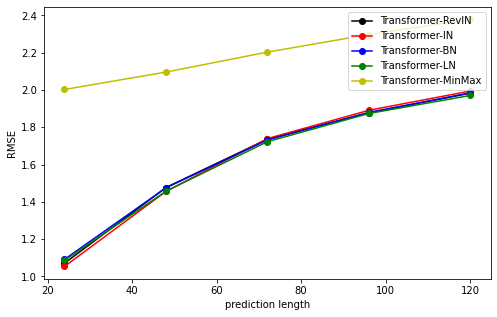

In [17]:
x_axis = exp_pred_len[exp_pred_len['norms'] == 'RevIN'].pred_len

plt.figure(1, figsize = (8,5))
plt.plot(x_axis, exp_pred_len[exp_pred_len['norms'] == 'RevIN'].rmse, 'ko-', label = 'Transformer-RevIN')
plt.plot(x_axis, exp_pred_len[exp_pred_len['norms'] == 'IN'].rmse, 'ro-', label = 'Transformer-IN')
plt.plot(x_axis, exp_pred_len[exp_pred_len['norms'] == 'BN'].rmse, 'bo-',label = 'Transformer-BN')
plt.plot(x_axis, exp_pred_len[exp_pred_len['norms'] == 'LN'].rmse, 'go-',label = 'Transformer-LN')
plt.plot(x_axis, exp_pred_len[exp_pred_len['norms'] == 'MinMax'].rmse, 'yo-',label = 'Transformer-MinMax')
plt.xlabel("prediction length")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')